## Imports

In [1]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import importlib

### Loading Repo

In [2]:
!git clone -b talib-1 http://github.com/Zapy67/ATML-PA-2

fatal: destination path 'ATML-PA-2' already exists and is not an empty directory.


In [70]:
!git pull http://github.com/Zapy67/ATML-PA-2 talib-1

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 1.47 MiB | 5.89 MiB/s, done.
From http://github.com/Zapy67/ATML-PA-2
 * branch            talib-1    -> FETCH_HEAD
Updating 1d58f66..8a9b368
Fast-forward
 DANN & CDAN/CDAN.py    |   2 +-
 DANN & CDAN/cdan.ipynb | 602 +++++++++++++++++++++++++++++--------------------
 2 files changed, 363 insertions(+), 241 deletions(-)


In [4]:
%cd ATML-PA-2/

/kaggle/working/ATML-PA-2


In [5]:
%cd "DANN & CDAN"

/kaggle/working/ATML-PA-2/DANN & CDAN


In [48]:
!ls

cdan.ipynb  CDAN.py  dann.ipynb  DANN.py  __pycache__  train.py  utils


In [8]:
from utils.dataset import MEAN, STD, OfficeHomeDataset
import utils
import os
from torchvision.models import ResNet50_Weights

importlib.reload(utils)

<module 'utils' from '/kaggle/working/ATML-PA-2/DANN & CDAN/utils/__init__.py'>

### Loading Dataset

In [9]:
root_dir = '/kaggle/input/officehome/OfficeHomeDataset_10072016'
csv_file = '/kaggle/input/officehome/OfficeHomeDataset_10072016/ImageInfo.csv'

In [10]:
transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [11]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, target, transform)

(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                                link  
0  http://img03.deviantart.net/6533/i/2012/052/0/...  
1  http://img07.deviantart.net/a073/i/2011/214/5/...  
2  http://img08.deviantart.net/955f/i/2011/226/b/...  
3  http://img06.deviantart.net/d6fe/i/2006/177/7/...  
4  http://orig04.deviantart.net/7945/f/2013/237/b...  
(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                  

In [12]:
source_loader = DataLoader(source_ds, batch_size=32, shuffle=True, num_workers=2)
target_loader = DataLoader(target_ds, batch_size=32, shuffle=True, num_workers=2)

In [13]:
def denormalize(img_tensor, mean=MEAN, std=STD):
    """Undo normalization on a single image tensor (C,H,W) → numpy (H,W,C) in [0,1]."""
    img = img_tensor.clone().cpu()
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    img = img.permute(1, 2, 0).clamp(0, 1)
    return img.numpy()

In [14]:
def show_images_from_dataset(dataset, n=8, title="Sample Images"):
    """
    Displays 'n' random images from the OfficeHomeDataset with class names.
    """
    plt.figure(figsize=(3 * n, 3))
    indices = torch.randperm(len(dataset))[:n]

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = denormalize(img)
        label_name = list(dataset.class_to_idx.keys())[label]

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label_name, fontsize=9)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


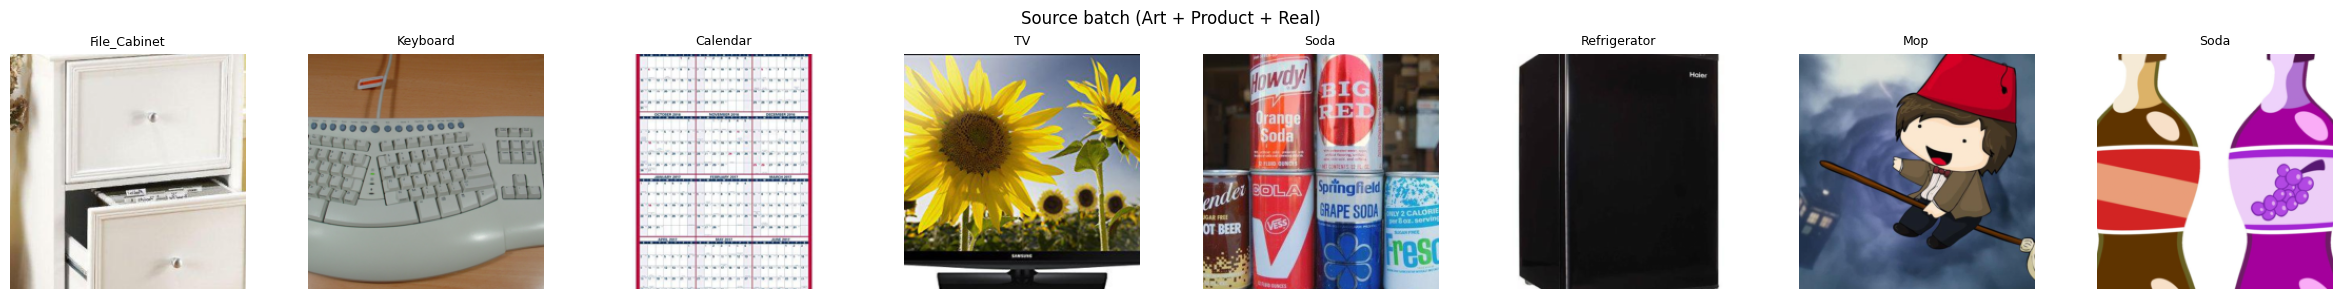

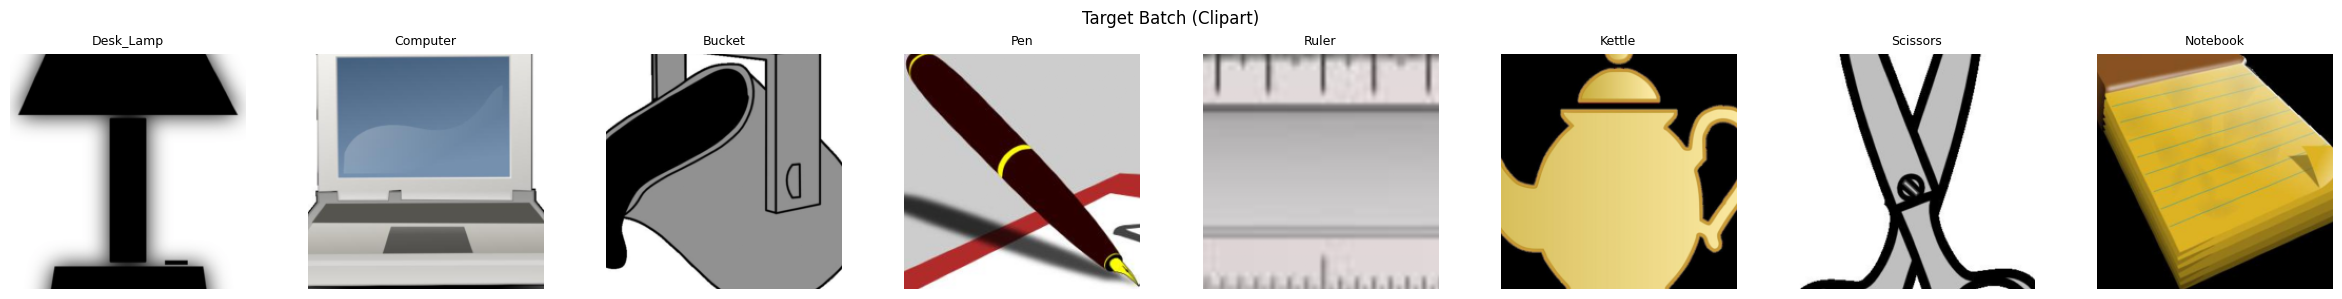

In [15]:
# show source images
show_images_from_dataset(source_ds, title="Source batch (Art + Product + Real)")
# show target images
show_images_from_dataset(target_ds, title="Target Batch (Clipart)")

## CDAN Training

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [71]:
import CDAN as cdan
importlib.reload(cdan)
importlib.reload(utils.dataset)

<module 'utils.dataset' from '/kaggle/working/ATML-PA-2/DANN & CDAN/utils/dataset.py'>

In [18]:
from utils.dataset import FeatureTensorDataset
from torchvision.models import resnet50

In [19]:
import torch.nn as nn
class RestWrapper(nn.Module):
    """Wrap the `truncate_from(resnet, 'layer3')` module so it returns (B, D)
       and exposes output_dim attribute expected by DANN class."""
    def __init__(self, rest_module, output_dim=1024):
        super().__init__()
        self.rest = rest_module
        self.output_dim = output_dim

    def forward(self, featmap):
        out = self.rest(featmap)
        if out.dim() == 4:
            out = torch.flatten(out, 1)
        elif out.dim() == 2:
            # already flattened
            pass
        else:
            # keep guard
            out = out.view(out.size(0), -1)
        return out

In [20]:
def truncate_up_to(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        seq.add_module(name, module)
        if name == layer_name:
            break
    return seq

def truncate_from(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seen = False
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        if seen and name != 'fc':    # exclude final fc
            seq.add_module(name, module)
        if name == layer_name:
            seen = True
    return seq

def freeze_until(resnet: nn.Module, layer_name: str):
    freeze = True
    for name, module in resnet.named_children():
        if freeze:
            for p in module.parameters():
                p.requires_grad = False
        if name == layer_name:
            freeze = False

In [72]:
base_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
freeze_until(base_resnet, 'layer3')

In [22]:
cache_source = utils.dataset.FeatureTensorDataset(dataset=source_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)
cache_target = utils.dataset.FeatureTensorDataset(dataset=target_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)

Precomputing up to layer3: 100%|██████████| 137/137 [00:19<00:00,  6.97it/s]


In [73]:
rest = truncate_from(base_resnet, 'layer3')
rest_wrapper = RestWrapper(rest, output_dim=2048).to(device)

In [74]:
model = cdan.CDAN(num_classes=65, resnet=rest_wrapper, use_entropy=True)

In [75]:
src_loader = DataLoader(cache_source, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
tgt_loader = DataLoader(cache_target, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
trainer = cdan.CDANTrainer(
        model=model,
        device=device,
        learning_rate=2e-4,
        weight_decay=5e-4,
        gamma=5.0,
        max_grad_norm=1.0,
        label_smoothing=0.0
    )

In [77]:
trainer.train(source_loader=src_loader, target_loader=tgt_loader, num_epochs=10)

Epoch 1/10: 100%|██████████| 351/351 [01:09<00:00,  5.02it/s, cls_loss=1.0890, dom_loss=1.3664, cls_acc=0.7391, alpha=0.0000]
                                                                    

Epoch 1/10 - Train Loss: 3.5005, Train Acc: 0.6389, Target Acc: 0.3805


Epoch 2/10: 100%|██████████| 351/351 [01:11<00:00,  4.93it/s, cls_loss=1.1586, dom_loss=1.3866, cls_acc=0.6522, alpha=0.4621]
                                                                    

Epoch 2/10 - Train Loss: 2.8991, Train Acc: 0.7841, Target Acc: 0.3892


Epoch 3/10: 100%|██████████| 351/351 [01:10<00:00,  4.95it/s, cls_loss=0.6286, dom_loss=1.3868, cls_acc=0.8696, alpha=0.7616]
                                                                    

Epoch 3/10 - Train Loss: 2.6588, Train Acc: 0.8452, Target Acc: 0.4142


Epoch 4/10: 100%|██████████| 351/351 [01:11<00:00,  4.94it/s, cls_loss=1.1365, dom_loss=1.3906, cls_acc=0.6957, alpha=0.9051]
                                                                    

Epoch 4/10 - Train Loss: 2.5317, Train Acc: 0.8801, Target Acc: 0.3908


Epoch 5/10: 100%|██████████| 351/351 [01:11<00:00,  4.94it/s, cls_loss=0.4443, dom_loss=1.3895, cls_acc=0.8696, alpha=0.9640]
                                                                    

Epoch 5/10 - Train Loss: 2.4582, Train Acc: 0.8981, Target Acc: 0.3805


Epoch 6/10: 100%|██████████| 351/351 [01:10<00:00,  4.96it/s, cls_loss=0.2689, dom_loss=1.3955, cls_acc=0.9565, alpha=0.9866]
                                                                    

Epoch 6/10 - Train Loss: 2.3851, Train Acc: 0.9239, Target Acc: 0.3929


Epoch 7/10: 100%|██████████| 351/351 [01:08<00:00,  5.11it/s, cls_loss=0.2387, dom_loss=1.3833, cls_acc=0.9565, alpha=0.9951]
                                                                    

Epoch 7/10 - Train Loss: 2.3537, Train Acc: 0.9325, Target Acc: 0.3973


Epoch 8/10: 100%|██████████| 351/351 [01:07<00:00,  5.18it/s, cls_loss=0.1588, dom_loss=1.3930, cls_acc=1.0000, alpha=0.9982]
                                                                    

Epoch 8/10 - Train Loss: 2.3186, Train Acc: 0.9434, Target Acc: 0.4007


Epoch 9/10: 100%|██████████| 351/351 [01:11<00:00,  4.94it/s, cls_loss=0.2946, dom_loss=1.3782, cls_acc=0.9130, alpha=0.9993]
                                                                    

Epoch 9/10 - Train Loss: 2.2972, Train Acc: 0.9495, Target Acc: 0.4002


Epoch 10/10: 100%|██████████| 351/351 [01:10<00:00,  4.95it/s, cls_loss=0.3556, dom_loss=1.3887, cls_acc=0.9130, alpha=0.9998]


Epoch 10/10 - Train Loss: 2.2656, Train Acc: 0.9572, Target Acc: 0.3952



=== SOURCE REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.9916    0.9916    0.9916       239
    Backpack     0.9958    1.0000    0.9979       239
   Batteries     1.0000    1.0000    1.0000       153
         Bed     0.9940    1.0000    0.9970       166
        Bike     1.0000    1.0000    1.0000       218
      Bottle     1.0000    1.0000    1.0000       239
      Bucket     0.9940    1.0000    0.9970       167
  Calculator     1.0000    1.0000    1.0000       187
    Calendar     0.9941    0.9941    0.9941       169
     Candles     1.0000    1.0000    1.0000       231
       Chair     0.9962    0.9962    0.9962       264
  Clipboards     1.0000    1.0000    1.0000       155
    Computer     0.9797    0.9461    0.9626       204
       Couch     0.9951    1.0000    0.9976       204
    Curtains     1.0000    1.0000    1.0000       188
   Desk_Lamp     0.9940    0.9821    0.9880       168
       Drill     1.0000    1.0000    1.0000       133
    

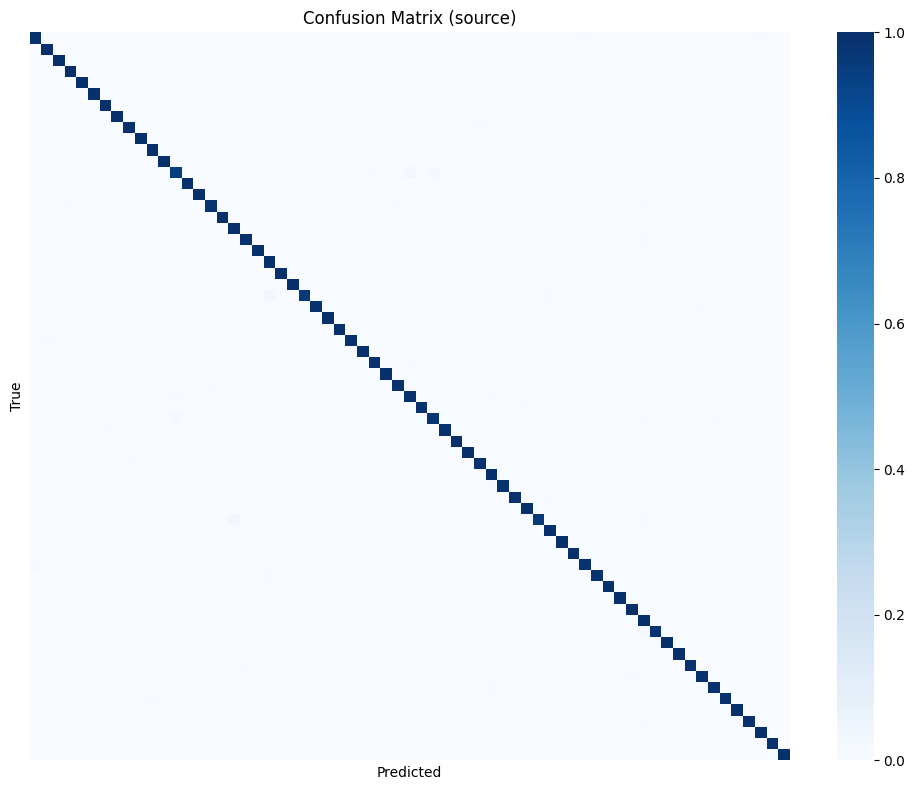

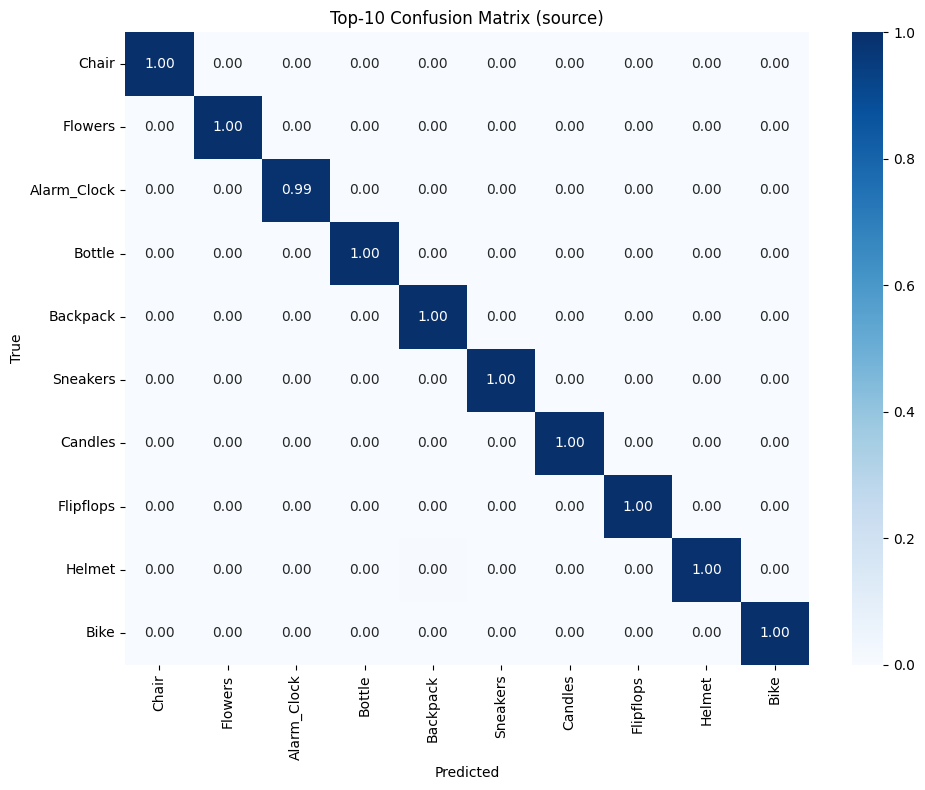


=== TARGET REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.7586    0.7333    0.7458        60
    Backpack     0.7000    0.3750    0.4884        56
   Batteries     0.5862    0.2656    0.3656        64
         Bed     0.4884    0.2143    0.2979        98
        Bike     0.6574    0.7172    0.6860        99
      Bottle     0.4444    0.2828    0.3457        99
      Bucket     0.3115    0.5205    0.3897        73
  Calculator     0.4505    0.8913    0.5985        46
    Calendar     0.5595    0.6026    0.5802        78
     Candles     0.3667    0.2222    0.2767        99
       Chair     0.4945    0.4545    0.4737        99
  Clipboards     0.6000    0.1500    0.2400        40
    Computer     0.5493    0.3939    0.4588        99
       Couch     0.2340    0.1719    0.1982        64
    Curtains     0.5312    0.8095    0.6415        42
   Desk_Lamp     0.0822    0.1463    0.1053        41
       Drill     0.6333    0.3958    0.4872        48
    

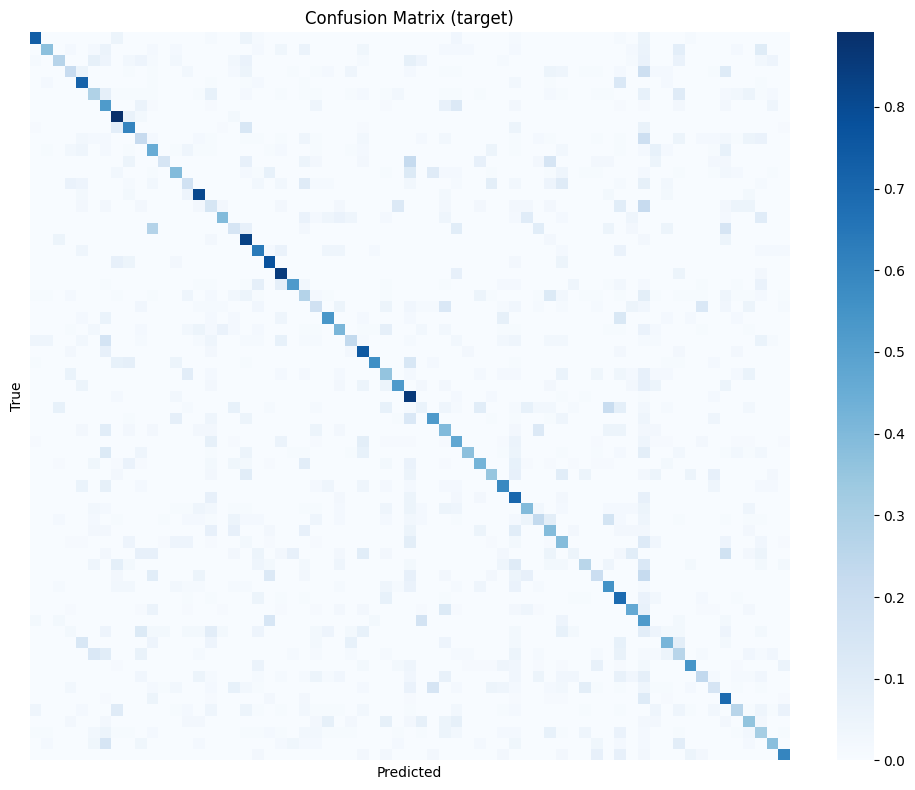

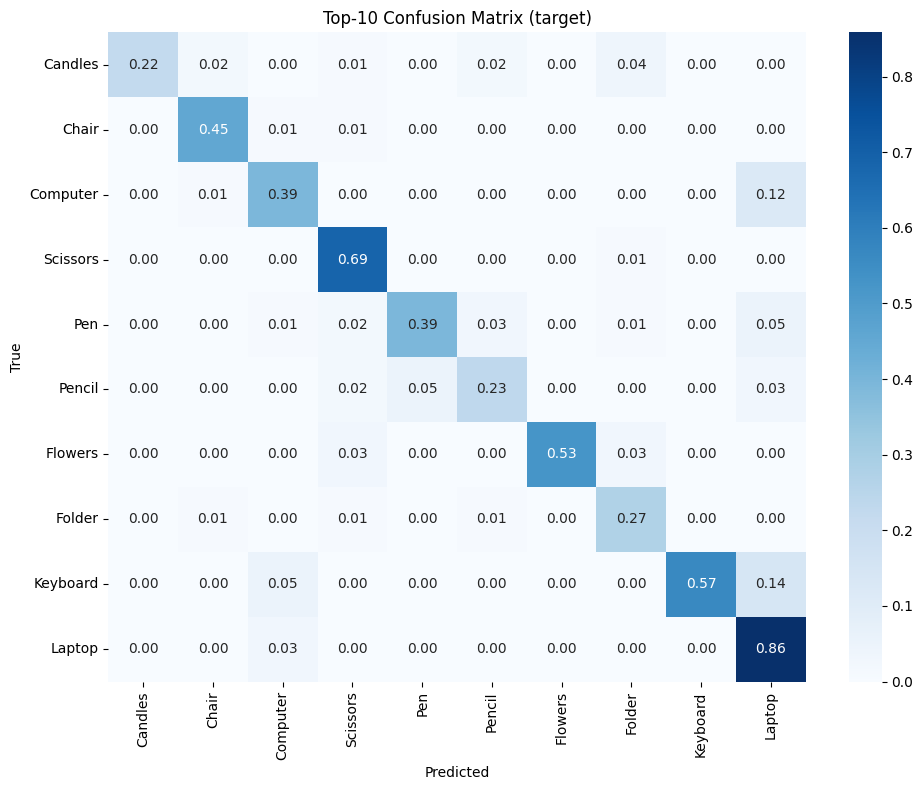

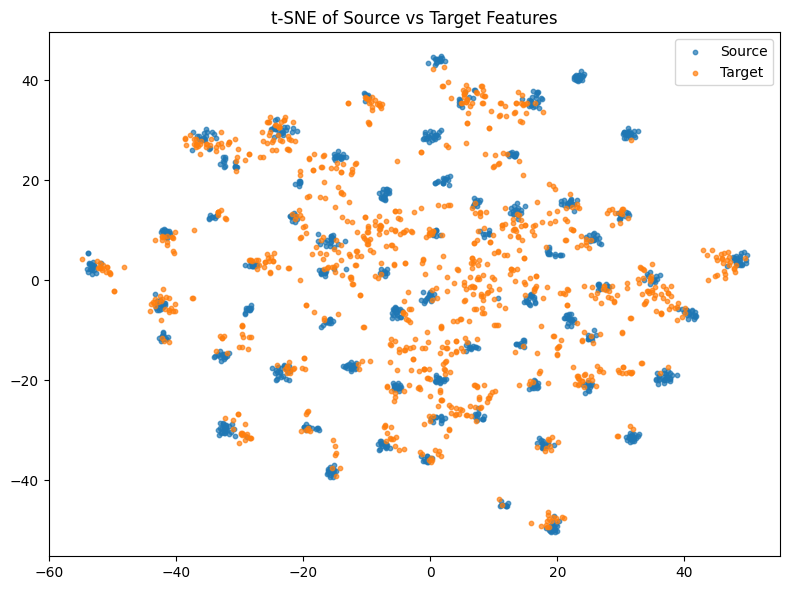

{'tsne': array([[ 17.002115 ,  37.7035   ],
        [ 23.0052   ,  40.673325 ],
        [  1.3510771, -19.508    ],
        ...,
        [-43.261314 ,  -5.0665164],
        [ 30.352364 ,  14.290816 ],
        [-41.040646 ,  -3.498538 ]], dtype=float32),
 'source': {'report': '              precision    recall  f1-score   support\n\n Alarm_Clock     0.9916    0.9916    0.9916       239\n    Backpack     0.9958    1.0000    0.9979       239\n   Batteries     1.0000    1.0000    1.0000       153\n         Bed     0.9940    1.0000    0.9970       166\n        Bike     1.0000    1.0000    1.0000       218\n      Bottle     1.0000    1.0000    1.0000       239\n      Bucket     0.9940    1.0000    0.9970       167\n  Calculator     1.0000    1.0000    1.0000       187\n    Calendar     0.9941    0.9941    0.9941       169\n     Candles     1.0000    1.0000    1.0000       231\n       Chair     0.9962    0.9962    0.9962       264\n  Clipboards     1.0000    1.0000    1.0000       155\n    Co

In [46]:
trainer.analysis(src_loader, tgt_loader, class_names= source_ds.classes,random_state=42)